In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

In [3]:
from sklearn.cross_validation import train_test_split

/Users/Patrick/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
df_train_var = pd.read_csv("Original_Data/training_variants")
df_test_var = pd.read_csv("Original_Data/test_variants")
df_train_txt = pd.read_csv('Original_Data/training_text', sep='\|\|', header=None, skiprows=1,names=["ID","Text"])
df_test_txt = pd.read_csv('Original_Data/test_text', sep='\|\|', header=None, skiprows=1,names=["ID","Text"])

/Users/Patrick/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/Users/Patrick/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [4]:
df_test_txt.to_pickle('df_test_txt.pkl')
df_train_txt.to_pickle('df_train_txt.pkl')
df_test_var.to_pickle('df_test_var.pkl')
df_train_var.to_pickle('df_train_var.pkl')

NameError: name 'df_test_txt' is not defined

In [5]:
df_test_txt = pd.read_pickle('df_test_txt.pkl')
df_train_txt = pd.read_pickle('df_train_txt.pkl')
df_test_var = pd.read_pickle('df_test_var.pkl')
df_train_var = pd.read_pickle('df_train_var.pkl')

In [6]:
df_test_var.shape

(5668, 3)

In [7]:
df_train_var.shape

(3321, 4)

In [4]:
import re
from stop_words import get_stop_words

stop_words = get_stop_words('english')

def remove_pun(text):
    s = re.sub(r'[^\w\s\d]','',text)
    s = re.sub(r'[\s][\d]+[\s]', ' ', s)   
    s = ' '.join([w for w in s.split() if not w.lower() in stop_words])
    return s

sent = "string$%. sd 0.5 m*l With. 0.5 ad P145A Punctuation?"
sent = remove_pun(sent)
sent

'string sd ml ad P145A Punctuation'

In [5]:
# WARNING: TAKES A FEW MINUTES

df_train_txt['Text_cleaned'] = df_train_txt.Text.apply(remove_pun)
df_test_txt['Text_cleaned'] =  df_test_txt.Text.apply(remove_pun)

In [6]:
# merge text and var datasets
# training datasets 
train_master = pd.merge(df_train_var, df_train_txt, how='left', on='ID').fillna('')

# test datasets 
test_master = pd.merge(df_test_var, df_test_txt, how='left', on='ID').fillna('')

In [7]:
all_master = train_master.drop('Class', axis=1).append(test_master)

In [8]:
train_master.to_pickle('train_master.pkl')
test_master.to_pickle('test_master.pkl')
all_master.to_pickle('all_master.pkl')

In [ ]:
train_master = pd.read_pickle('train_master.pkl')
test_master = pd.read_pickle('test_master.pkl')
all_master = pd.read_pickle('all_master.pkl')

### SVD

In [16]:
from sklearn.decomposition import TruncatedSVD

Gene_INPUT_DIM=25
Variation_INPUT_DIM=25


svd_gene = TruncatedSVD(n_components=Gene_INPUT_DIM, n_iter=25, random_state=56)
svd_variation = TruncatedSVD(n_components=Variation_INPUT_DIM, n_iter=25, random_state=56)

one_hot_gene = pd.get_dummies(all_master['Gene'])
truncated_one_hot_gene = svd_gene.fit_transform(one_hot_gene.values)

one_hot_variation = pd.get_dummies(all_master['Variation'])
truncated_one_hot_variation = svd_variation.fit_transform(one_hot_variation.values)


In [98]:
#Combine the SVD columns into a df and 

gene_svd = pd.DataFrame(truncated_one_hot_gene)
gene_svd.columns = ['gene_'+ str(col) for col in gene_svd.columns]
var_svd = pd.DataFrame(truncated_one_hot_variation)
var_svd.columns = ['variation_'+ str(col) for col in var_svd.columns]

train_size=len(train_master)

all_svd = gene_svd.join(var_svd)
train_svd = all_svd[:train_size].join(train_master['Class'])
test_svd = all_svd[train_size:]

In [64]:
### JUST THE VARIATION SVD FEATURES

all_svd_var = var_svd
train_svd_var = all_svd_var[:train_size].join(train_master['Class'])
test_svd_var = all_svd_var[train_size:]

### Amino Acid Feature Engineering

In [11]:
## AMINO ACID FEATURE ENGINEERING

def orig_amino(text):
    if text.upper() == text:
        return text[0]
    else:
        return 0

def mutated_amino(text):
    if text.upper() == text:
        return text[-1]
    else:
        return 0

In [12]:
amino = pd.read_csv('Amino_Acids.csv')

In [23]:
all_master['Original_Amino'] = all_master['Variation'].apply(orig_amino)
all_master['Mutated_Amino'] = all_master['Variation'].apply(mutated_amino)

aminoFeatures = pd.merge(all_master[['ID', 'Original_Amino', 'Mutated_Amino']],
         amino[['Letter', 'Isoelectric_P', 'Hydrophobicity']],
         how = 'left', left_on= 'Original_Amino', right_on = 'Letter')

aminoFeatures = aminoFeatures.rename(columns = {'Isoelectric_P': 'orig_elec', 'Hydrophobicity': 'orig_hydro'})

aminoFeatures = pd.merge(aminoFeatures,amino[['Letter', 'Isoelectric_P', 'Hydrophobicity']],
         how = 'left', left_on= 'Mutated_Amino', right_on = 'Letter')

aminoFeatures['Elec_Diff'] = abs(aminoFeatures['orig_elec'].subtract(aminoFeatures['Isoelectric_P']))
aminoFeatures['Hydro_Diff'] = abs(aminoFeatures['orig_hydro'].subtract(aminoFeatures['Hydrophobicity']))
aminoFeatures = aminoFeatures.drop(['Original_Amino', 'Mutated_Amino', 'orig_elec', 'orig_hydro', 
                                    'Isoelectric_P','Hydrophobicity'], axis=1).fillna(0)\
            .rename(columns = {'Letter_x': 'Orig_Amino', 'Letter_y': 'Mut_Amino'})

aminoFeatures_all = pd.get_dummies(aminoFeatures)

In [24]:
train_master['Original_Amino'] = train_master['Variation'].apply(orig_amino)
train_master['Mutated_Amino'] = train_master['Variation'].apply(mutated_amino)

aminoFeatures = pd.merge(train_master[['ID', 'Original_Amino', 'Mutated_Amino']],
         amino[['Letter', 'Isoelectric_P', 'Hydrophobicity']],
         how = 'left', left_on= 'Original_Amino', right_on = 'Letter')

aminoFeatures = aminoFeatures.rename(columns = {'Isoelectric_P': 'orig_elec', 'Hydrophobicity': 'orig_hydro'})

aminoFeatures = pd.merge(aminoFeatures,amino[['Letter', 'Isoelectric_P', 'Hydrophobicity']],
         how = 'left', left_on= 'Mutated_Amino', right_on = 'Letter')

aminoFeatures['Elec_Diff'] = abs(aminoFeatures['orig_elec'].subtract(aminoFeatures['Isoelectric_P']))
aminoFeatures['Hydro_Diff'] = abs(aminoFeatures['orig_hydro'].subtract(aminoFeatures['Hydrophobicity']))
aminoFeatures = aminoFeatures.drop(['Original_Amino', 'Mutated_Amino', 'orig_elec', 'orig_hydro', 
                                    'Isoelectric_P','Hydrophobicity'], axis=1).fillna(0)\
            .rename(columns = {'Letter_x': 'Orig_Amino', 'Letter_y': 'Mut_Amino'})
    
aminoFeatures_train = pd.get_dummies(aminoFeatures)

In [25]:
test_master['Original_Amino'] = test_master['Variation'].apply(orig_amino)
test_master['Mutated_Amino'] = test_master['Variation'].apply(mutated_amino)

aminoFeatures = pd.merge(test_master[['ID', 'Original_Amino', 'Mutated_Amino']],
         amino[['Letter', 'Isoelectric_P', 'Hydrophobicity']],
         how = 'left', left_on= 'Original_Amino', right_on = 'Letter')

aminoFeatures = aminoFeatures.rename(columns = {'Isoelectric_P': 'orig_elec', 'Hydrophobicity': 'orig_hydro'})

aminoFeatures = pd.merge(aminoFeatures,amino[['Letter', 'Isoelectric_P', 'Hydrophobicity']],
         how = 'left', left_on= 'Mutated_Amino', right_on = 'Letter')

aminoFeatures['Elec_Diff'] = abs(aminoFeatures['orig_elec'].subtract(aminoFeatures['Isoelectric_P']))
aminoFeatures['Hydro_Diff'] = abs(aminoFeatures['orig_hydro'].subtract(aminoFeatures['Hydrophobicity']))
aminoFeatures = aminoFeatures.drop(['Original_Amino', 'Mutated_Amino', 'orig_elec', 'orig_hydro', 
                                    'Isoelectric_P','Hydrophobicity'], axis=1).fillna(0)\
            .rename(columns = {'Letter_x': 'Orig_Amino', 'Letter_y': 'Mut_Amino'})
    
aminoFeatures_test = pd.get_dummies(aminoFeatures)

In [96]:
aminoFeatures_train.columns.values

array(['ID', 'Elec_Diff', 'Hydro_Diff', 'Orig_Amino_0', 'Orig_Amino_A',
       'Orig_Amino_C', 'Orig_Amino_D', 'Orig_Amino_E', 'Orig_Amino_F',
       'Orig_Amino_G', 'Orig_Amino_H', 'Orig_Amino_I', 'Orig_Amino_K',
       'Orig_Amino_L', 'Orig_Amino_M', 'Orig_Amino_N', 'Orig_Amino_P',
       'Orig_Amino_Q', 'Orig_Amino_R', 'Orig_Amino_S', 'Orig_Amino_T',
       'Orig_Amino_V', 'Orig_Amino_W', 'Orig_Amino_Y', 'Mut_Amino_0',
       'Mut_Amino_A', 'Mut_Amino_C', 'Mut_Amino_D', 'Mut_Amino_E',
       'Mut_Amino_F', 'Mut_Amino_G', 'Mut_Amino_H', 'Mut_Amino_I',
       'Mut_Amino_K', 'Mut_Amino_L', 'Mut_Amino_M', 'Mut_Amino_N',
       'Mut_Amino_P', 'Mut_Amino_Q', 'Mut_Amino_R', 'Mut_Amino_S',
       'Mut_Amino_T', 'Mut_Amino_V', 'Mut_Amino_W', 'Mut_Amino_Y'], dtype=object)

In [43]:
train_svd['ID'] = train_svd.index

In [ ]:
all_svd = all_svd.join(aminoFeatures_all)
train_svd = train_svd.join(aminoFeatures_train)
test_svd = test_svd.join(aminoFeatures_test)

In [44]:
print(all_svd.shape)
print(train_svd.shape)
print(test_svd.shape)

(8989, 94)
(3321, 96)
(5668, 95)


### Models with SVD

In [100]:
X_train, X_test, y_train, y_test = train_test_split(train_svd.drop('Class', axis=1), train_svd['Class'], test_size=0.2, random_state=42)

In [47]:
#Multiclass Logistic Regression
import sklearn
from sklearn.linear_model import LogisticRegression

multinomial = LogisticRegression(multi_class='ovr', ### one-vs-rest
                                 class_weight='balanced',
                                 solver='liblinear',
                                 penalty='l1',
                                 C=.1)

multinomial.fit(X_train, y_train)
print('Accuracy score: ' + str(multinomial.score(X_test, y_test)))
multinomial_pred = multinomial.predict(X_test)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,multinomial_pred))

Accuracy score: 0.359398496241
confusion_matrix:
 [[49  0  0  7  7  3 22  6 20]
 [ 1 22  3  3  0  0 35  8 24]
 [ 0  0  7  2  3  0  2  1  4]
 [17  0  0 25  9  1 51  7 29]
 [ 1  0  1  0 21  5 12  2  8]
 [ 2  1  0  3  6 15 13  3  2]
 [ 0 36 21  6  0  0 98 11 22]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  5  0  2]]


### Doc2Vec

In [6]:
#import packages

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
import os

Using TensorFlow backend.


In [10]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence

In [11]:
# train/test splits

X_train, X_test, y_train, y_test = train_test_split(train_master['Text_cleaned'], train_master['Class'], test_size=0.2, random_state=42)

In [12]:
X_new = test_master['Text_cleaned']

In [13]:
#Do some very minor text preprocessing
def preprocessText(corpus):
    corpus = [z.split() for z in corpus]
    return corpus

In [14]:
X_train = preprocessText(X_train)
X_test = preprocessText(X_test)
X_new = preprocessText(X_new)

In [15]:
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

In [16]:
#Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.

#We do this by using the LabeledSentence method. The format will be "TRAIN_i" or "TEST_i" where "i" is
#a dummy index of the paper text.

def labelizePapers(papers, label_type):
    labelized = []
    for i,v in enumerate(papers):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

In [17]:
X_train = labelizePapers(X_train, 'TRAIN')
X_test = labelizePapers(X_test, 'TEST')
X_new = labelizePapers(X_new, 'UNSUP')

In [18]:
import itertools

In [19]:
#build vocab over all reviews
X_all = X_train + X_test + X_new

In [ ]:
d2v_model_dm = Doc2Vec.load('models/doc2vec_dm')

In [70]:
d2v_model_dbow = Doc2Vec.load('models/doc2vec_dbow')

In [21]:
d2v_model_dbow_sg = Doc2Vec.load('models/doc2vec_dbow_sg')

In [18]:
#instantiate our DM and DBOW models
d2v_model_dm = gensim.models.Doc2Vec(min_count=3, window=7, size=400, sample=1e-3, negative=5, workers=2)
d2v_model_dbow = gensim.models.Doc2Vec(min_count=3, window=7, size=400, sample=1e-3, negative=5, dm=0, workers=2)
d2v_model_dbow_sg = gensim.models.Doc2Vec(min_count=3, window=7, size=400, sample=1e-3, negative=5, dm=0, dbow_words=1, workers=2)


In [20]:
d2v_model_dbow.build_vocab(X_all)
d2v_model_dbow_sg.build_vocab(X_all)

In [22]:
# train the DM model on the training set
# replace X_train with X_all
# WARNING: TAKES 2.25 HOURS TO RUN ON PMP'S COMPUTER

d2v_model_dm.train(X_all,
                   total_examples=d2v_model_dm.corpus_count,
                   epochs=d2v_model_dm.iter)


228822356

In [21]:
# train the DBOW model on training set
# WARNING: TAKES 15 MINUTES

d2v_model_dbow.train(X_all,
                     total_examples=d2v_model_dbow.corpus_count,
                     epochs=d2v_model_dbow.iter)


228825306

In [22]:
# train the DBOW Skip Gram model on training set

d2v_model_dbow_sg.train(X_all,
                        total_examples=d2v_model_dbow_sg.corpus_count,
                        epochs=d2v_model_dbow_sg.iter)

228821351

In [23]:
d2v_model_dm.save('models/doc2vec_dm')

In [101]:
# save the two models
os.makedirs('models')
d2v_model_dm.save('models/doc2vec_dm')

d2v_model_dbow.save('models/doc2vec_dbow')

In [24]:
d2v_model_dbow.save('models/doc2vec_dbow')

In [25]:
d2v_model_dbow_sg.save('models/doc2vec_dbow_sg')

In [ ]:
import pickle

pickle.dump(d2v_model_dbow, open('models/d2v_model_dbow.sav', 'wb'))

In [ ]:
pickle.dump(d2v_model_dbow_sg, open('models/d2v_model_dbow_sg.sav', 'wb'))

In [24]:
# infer DM vectors for training set and save to a list
# WARNING: TAKES 15 MINUTES ON PMP'S COMPUTER

train_vecs_dm = []

for doc in X_train:
    vec = d2v_model_dm.infer_vector(doc.words)
    train_vecs_dm.append(vec)


In [71]:
# infer DBOW vectors for training set and save to a list
train_vecs_dbow = []

for doc in X_train:
    vec = d2v_model_dbow.infer_vector(doc.words)
    train_vecs_dbow.append(vec)

AttributeError: 'KeyedVectors' object has no attribute 'syn0'

In [23]:
# infer DBOW SG vectors for training set and save to a list
train_vecs_dbow_sg = []

for doc in X_train:
    vec = d2v_model_dbow_sg.infer_vector(doc.words)
    train_vecs_dbow_sg.append(vec)

In [25]:
# infer DM vectors for test set and save to a list
# WARNING: TAKES 5 MINS ON PMP'S COMPUTER

test_vecs_dm = []

for doc in X_test:
    vec = d2v_model_dm.infer_vector(doc.words)
    test_vecs_dm.append(vec)

In [110]:
# infer DBOW vectors for test set and save to a list

test_vecs_dbow = []

for doc in X_test:
    vec = d2v_model_dbow.infer_vector(doc.words)
    test_vecs_dbow.append(vec)

In [24]:
# infer DBOW SG vectors for test set and save to a list

test_vecs_dbow_sg = []

for doc in X_test:
    vec = d2v_model_dbow_sg.infer_vector(doc.words)
    test_vecs_dbow_sg.append(vec)

In [25]:
# infer DBOW SG vectors for new test set (for kaggle submission) and save to a list

new_vecs_dbow_sg = []

for doc in X_new:
    vec = d2v_model_dbow_sg.infer_vector(doc.words)
    new_vecs_dbow_sg.append(vec)

### SGD Classifier

In [34]:
from sklearn.linear_model import SGDClassifier

# train 

lr_dm = SGDClassifier(loss='log', penalty='l1', class_weight='balanced')
lr_dm.fit(train_vecs_dm, y_train)

print('DM Test Accuracy: %.2f'%lr_dm.score(test_vecs_dm, y_test))

/Users/Patrick/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


DM Test Accuracy: 0.55


In [128]:
# save SGD model
import pickle

pickle.dump(lr_dm, open('models/sgd_dm_model.sav', 'wb'))

In [129]:
# read in the saved model
sgd_lm_model = pickle.load(open('models/sgd_dm_model.sav', 'rb'))

In [130]:
sgd_lm_model.score(test_vecs_dm, y_test)

0.55338345864661653

In [114]:
lr_dbow = SGDClassifier(loss='log', penalty='l1',class_weight='balanced')
lr_dbow.fit(train_vecs_dbow, y_train)

print('DBOW Test Accuracy: %.2f'%lr_dbow.score(test_vecs_dbow, y_test))

/Users/Patrick/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


DBOW Test Accuracy: 0.47


In [35]:
# save the predicted classes
test_predict_dm = lr_dm.predict(test_vecs_dm)

In [30]:
import sklearn

In [36]:
print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,test_predict_dm))

confusion_matrix:
 [[ 73   5   1  19   7   4   5   0   0]
 [  8  43   1   2   5   6  31   0   0]
 [  2   1  11   3   1   0   1   0   0]
 [ 34   7   5  78   5   5   5   0   0]
 [ 17   7   1   8  11   3   3   0   0]
 [  4   2   0   3   4  31   1   0   0]
 [  6  33   3  11  10  11 117   1   2]
 [  0   0   0   0   0   0   1   0   0]
 [  1   0   0   1   0   0   0   1   4]]


### Support Vector Classifier

In [274]:
from sklearn.svm import SVC

svm = SVC(class_weight='balanced', probability=True) ### NOTE: balanced has worse score than 'None', but balanced better in theory
svm.fit(train_nn_svd_dbow_sg, y_train)

print('Accuracy score: ' + str(svm.score(test_nn_svd_dbow_sg, y_test)))
svm_pred = svm.predict(test_nn_svd_dbow_sg)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,svm_pred))

Accuracy score: 0.563909774436
confusion_matrix:
 [[ 84   5   1   6  12   0   4   2   0]
 [  5  50   0   0   4   2  34   1   0]
 [  2   0  13   2   0   0   2   0   0]
 [ 59   3   2  45  13   3  13   1   0]
 [ 12   0   0   3  22   3  10   0   0]
 [  5   2   0   1   2  30   5   0   0]
 [  4  43  10   1   7   0 126   3   0]
 [  0   0   0   0   0   0   0   0   1]
 [  0   1   0   0   1   0   0   0   5]]


In [275]:
#export predictions to csv

svm_new_predict_proba = svm.predict_proba(new_nn_svd_dbow_sg)

new_index = test_master['ID'].values

submission = pd.DataFrame(svm_new_predict_proba)
submission['id'] = new_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("svm_svd_d2v_pmp.csv",index=False)

In [131]:
# save SVM model

pickle.dump(svm, open('models/svm_dm_model.sav', 'wb'))

In [132]:
# read in the saved model
svm_lm_model = pickle.load(open('models/svm_dm_model.sav', 'rb'))

### Multinomial Logistic Classifier

In [268]:
## NOTE - next , do grid search on C (from 1e-4 to 1e5), multi-class

from sklearn.linear_model import LogisticRegression

multinomial = LogisticRegression(multi_class='ovr', ### one-vs-rest
                                 class_weight='balanced',
                                 solver='liblinear',
                                 penalty='l1',
                                 C=.1)

multinomial.fit(train_nn_svd_dbow_sg, y_train)
print('Accuracy score: ' + str(multinomial.score(test_nn_svd_dbow_sg, y_test)))
multinomial_pred = multinomial.predict(test_nn_svd_dbow_sg)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,multinomial_pred))

Accuracy score: 0.577443609023
confusion_matrix:
 [[ 63   1   1  21  10   8   5   4   1]
 [  1  45   0   3   5   2  37   3   0]
 [  1   0  12   2   0   1   3   0   0]
 [ 24   3   9  75  10   4   9   1   4]
 [  7   2   1   7  19   5   8   0   1]
 [  4   1   0   3   2  31   3   1   0]
 [  0  33   9   6   9   0 134   2   1]
 [  0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   1   0   0   1   5]]


In [ ]:
multinom_predict_proba = multinomial.predict_proba()

In [270]:
#export predictions to csv

multinom_new_predict_proba = multinomial.predict_proba(new_nn_svd_dbow_sg)

new_index = test_master['ID'].values

submission = pd.DataFrame(multinom_new_predict_proba)
submission['id'] = new_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("multinomlog_svd_d2v_pmp.csv",index=False)

In [133]:
# save Multinomial Logistic Classification model

pickle.dump(multinomial, open('models/multinomiallog_dm_model.sav', 'wb'))

In [134]:
# read in the saved model
multinomiallog_lm_model = pickle.load(open('models/multinomiallog_dm_model.sav', 'rb'))

In [45]:
# Multinomial Logistic CLassifier with 10 fold CV on C
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

#CV
C_range = [.0001,.001,.01,.1,1,10,100,1000,10000]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for c in C_range:
    multinomial = LogisticRegression(multi_class='ovr', 
                                 class_weight='balanced',
                                 solver='liblinear',
                                 penalty='l1',
                                 C=c)
    scores = cross_val_score(multinomial, train_vecs_dm, y_train, cv=10)
    cv_scores.append(scores.mean())

In [46]:
optimal_C = C_range[cv_scores.index(max(cv_scores))]
optimal_C

0.1

In [55]:
cv_scores

[0.17093229881377797,
 0.28687536391160434,
 0.40138085735626594,
 0.5530753109253852,
 0.52669123513238547,
 0.480764825222881,
 0.47471393406455975,
 0.47470830383856877,
 0.47281854403305906]

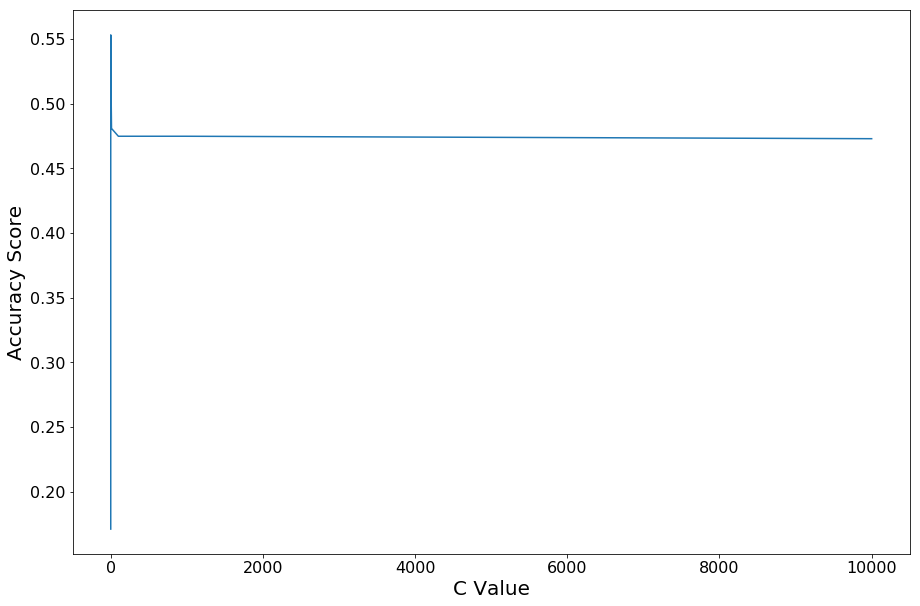

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(C_range, cv_scores)
plt.xlabel('C Value', fontsize = 20)
plt.ylabel('Accuracy Score', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()
#plt.savefig('knn_cross_valid.png')

### Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
# RF with AA FEATURES

rf = RandomForestClassifier(n_jobs=-1,
                            random_state=51,
                            n_estimators=800,  ### do gridsearch >100
                            max_depth=12,
                            min_samples_leaf=5,  
                            oob_score=True,
                            class_weight='balanced'
                           )

rf.fit(X_train, y_train)
print('Accuracy score: ' + str(rf.score(X_test, y_test)))
rf_pred = rf.predict(X_test)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,rf_pred))


Accuracy score: 0.396992481203
confusion_matrix:
 [[52  4  4 14  7  3 16  6  8]
 [ 1 47  3  2  0  1 32  4  6]
 [ 0  0 10  2  3  0  2  0  2]
 [25  4  1 42  9  5 24  8 21]
 [ 1  6  2  2 21  7  6  3  2]
 [ 2  5  2  1  6 19  8  1  1]
 [ 0 61 25  4  0  2 71 14 17]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  2]]


In [68]:
# RF single shot

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1,
                            random_state=51,
                            n_estimators=900,  ### do gridsearch >100
                            max_depth=40,
                            min_samples_leaf=5,  
                            oob_score=True,
                            class_weight='balanced'
                           )

rf.fit(train_vecs_dm, y_train)
print('Accuracy score: ' + str(rf.score(test_vecs_dm, y_test)))
rf_pred = rf.predict(test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,rf_pred))

Accuracy score: 0.639097744361
confusion_matrix:
 [[ 73   2   0  16   9   1  13   0   0]
 [  4  32   0   0   4   1  55   0   0]
 [  2   0   9   2   0   0   6   0   0]
 [ 35   1   1  81   5   1  15   0   0]
 [ 11   1   0   8  18   3   9   0   0]
 [  6   0   0   1   1  31   6   0   0]
 [  1   8   3   3   3   0 176   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   1   0   5]]


In [263]:
# RF Grid Search CV
from sklearn.ensemble import RandomForestClassifier

rf_params = {'max_depth':[15,20,30],
             'max_features':[12,15,20],
             'min_samples_leaf':[5,10,15]
            }

rf = RandomForestClassifier(n_jobs=-1,
                            n_estimators=900,
                            random_state=51,
                            oob_score=True,
                            class_weight='balanced'
                           )

rf_cv = GridSearchCV(rf,
                     param_grid=rf_params,
                     cv=5)

rf_cv.fit(train_nn_svd_dbow_sg, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=900, n_jobs=-1, oob_score=True, random_state=51,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [12, 15, 20], 'min_samples_leaf': [5, 10, 15], 'max_depth': [15, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [264]:
print(rf_cv.best_params_)

{'max_features': 15, 'min_samples_leaf': 5, 'max_depth': 15}


In [265]:
print(rf_cv.best_params_)
y_rf_pred = rf_cv.best_estimator_.predict(test_nn_svd_dbow_sg)

{'max_features': 15, 'min_samples_leaf': 5, 'max_depth': 15}


In [266]:
print('Accuracy score: ' + str(rf_cv.best_estimator_.score(test_nn_svd_dbow_sg, y_test)))

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,y_rf_pred))

Accuracy score: 0.634586466165
confusion_matrix:
 [[ 77   1   1  13   9   2  11   0   0]
 [  3  41   0   0   4   1  47   0   0]
 [  1   0  12   2   0   0   4   0   0]
 [ 26   1   3  79   7   1  22   0   0]
 [ 16   0   0   5  17   2  10   0   0]
 [  6   0   0   1   2  32   4   0   0]
 [  2  18   5   3   6   0 160   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   2   0   4]]


In [135]:
# save RF model

pickle.dump(rf_cv.best_estimator_, open('models/rf_dm_model.sav', 'wb'))

In [136]:
# read in the saved model
rf_lm_model = pickle.load(open('models/rf_dm_model.sav', 'rb'))

In [271]:
#export predictions to csv
rf_new_predict_proba = rf_cv.best_estimator_.predict_proba(new_nn_svd_dbow_sg)

new_index = test_master['ID'].values

submission = pd.DataFrame(rf_new_predict_proba)
submission['id'] = new_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("rf_svd_d2v_pmp.csv",index=False)

### Gradient Boosting Model

In [258]:
# GBM single shot

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate=.01,
                                random_state=13,
                                n_estimators=600,
                                max_features=20,
                                max_depth=15,
                                min_samples_leaf=5
                               )

gb.fit(train_nn_svd_dbow_sg, y_train)
print('Accuracy score: ' + str(gb.score(test_nn_svd_dbow_sg, y_test)))
gb_pred = gb.predict(test_nn_svd_dbow_sg)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,gb_pred))

Accuracy score: 0.678195488722
confusion_matrix:
 [[ 85   1   0  16   5   2   5   0   0]
 [  3  38   0   0   4   1  50   0   0]
 [  2   0   7   3   1   0   6   0   0]
 [ 18   0   1  95   4   1  20   0   0]
 [ 17   1   0  10  14   2   6   0   0]
 [  7   1   0   1   2  31   3   0   0]
 [  2   6   1   4   3   0 178   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   3   0   3]]


In [260]:
gb_new_predict_proba = gb.predict_proba(new_nn_svd_dbow_sg)

In [138]:
# save GBM model

pickle.dump(gb, open('models/gbm_dm_model.sav', 'wb'))

In [139]:
# read in the saved model
gbm_lm_model = pickle.load(open('models/gbm_dm_model.sav', 'rb'))

In [ ]:
# GBM grid search CV

parameters = {'n_estimators':[600,700,800],
              'learning_rate':[0.01,0.03,0.05]
             }


gb_reg = GradientBoostingClassifier(random_state=13,
                                    n_jobs=-1,
                                    max_depth=30,
                                    min_samples_leaf=5
                                   )

gb_cv = GridSearchCV(gb_reg,
                     param_grid=parameters,
                     cv=5)

gb_cv.fit(train_vecs_dm, y_train)

In [262]:
gb_new_predict_proba = gb.predict_proba(new_nn_svd_dbow_sg)

new_index = test_master['ID'].values

submission = pd.DataFrame(gb_new_predict_proba)
submission['id'] = new_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("gb_svd_d2v_pmp.csv",index=False)

### Multinomial Naive Bayes
#### Note: this is tough for Doc2Vec because some of the features (doc similarity vectors) are negative,
#### and MNB doesn't take negative inputs, so we have to scale them

In [89]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train_vecs_dm)
train_vecs_dm_scaled = scaler.transform(train_vecs_dm)

scaler.fit(test_vecs_dm)
test_vecs_dm_scaled = scaler.transform(test_vecs_dm)


In [91]:
# MNB single shot

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(train_vecs_dm_scaled, y_train)
print('Accuracy score: ' + str(mnb.score(test_vecs_dm_scaled, y_test)))
mnb_pred = mnb.predict(test_vecs_dm_scaled)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,mnb_pred))

Accuracy score: 0.485714285714
confusion_matrix:
 [[ 40   0   0  24   4   1  45   0   0]
 [  0   0   0   0   0   0  96   0   0]
 [  2   0   0   4   2   0  11   0   0]
 [ 27   0   0  57   5   0  50   0   0]
 [  6   0   0  11  14   5  14   0   0]
 [  0   0   0   6   0  21  18   0   0]
 [  3   0   0   3   0   0 188   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   4   0   3]]


In [140]:
# save Multinomial Naive Bayes model

pickle.dump(mnb, open('models/mnb_dm_model.sav', 'wb'))

In [141]:
# read in the saved model
mnb_lm_model = pickle.load(open('models/mnb_dm_model.sav', 'rb'))

### Gaussian Naive Bayes
#### Can take negative inputs

In [92]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(train_vecs_dm, y_train)
print('Accuracy score: ' + str(gnb.score(test_vecs_dm, y_test)))
gnb_pred = gnb.predict(test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,gnb_pred))


Accuracy score: 0.494736842105
confusion_matrix:
 [[ 57   9   5  19  18   2   3   1   0]
 [  2  43   8   8   4   1  30   0   0]
 [  2   0  15   1   0   0   1   0   0]
 [ 55   5  14  41  11   1  11   1   0]
 [ 10   3   1   4  24   3   5   0   0]
 [  4   2   2   3   0  29   5   0   0]
 [  6  39  19   6   4   2 116   2   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   1   0   0   1   0   0   1   4]]


In [142]:
# save Gaussian Naive Bayes model

pickle.dump(gnb, open('models/gnb_dm_model.sav', 'wb'))

In [143]:
# read in the saved model
gnb_lm_model = pickle.load(open('models/gnb_dm_model.sav', 'rb'))

### XGBoost

In [118]:
# Convert the train_vecs_dm and test_vecs_dm lists of np arrays to pd dfs for XGBoost

nrow_train = list(range(len(train_vecs_dm)))
nrow_test = list(range(len(test_vecs_dm)))

df_4 = pd.DataFrame.from_items(zip(nrow_train, train_vecs_dm))
xgb_train_vecs_dm = pd.DataFrame.transpose(df_4)

df_5 = pd.DataFrame.from_items(zip(nrow_test, test_vecs_dm))
xgb_test_vecs_dm = pd.DataFrame.transpose(df_5)

In [71]:
len(train_nn_svd_dbow_sg

2656

In [60]:
# prep the SVD and Doc2Vec features for XGB

nrow_train = list(range(len(train_nn_svd_dbow_sg)))
nrow_test = list(range(len(test_nn_svd_dbow_sg)))

df_4 = pd.DataFrame.from_items(zip(nrow_train, train_nn_svd_dbow_sg))
xgb_train_vecs_dbow_sg = pd.DataFrame.transpose(df_4)

df_5 = pd.DataFrame.from_items(zip(nrow_test, test_nn_svd_dbow_sg))
xgb_test_vecs_dbow_sg = pd.DataFrame.transpose(df_5)

In [61]:
nrow_new = list(range(len(new_nn_svd_dbow_sg)))

df_4 = pd.DataFrame.from_items(zip(nrow_new, new_nn_svd_dbow_sg))
xgb_new_vecs_dbow_sg = pd.DataFrame.transpose(df_4)


In [75]:
train_nn_svd_dbow_sg.columns.names

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [62]:
xgb_train_vecs_dbow_sg.shape

(2656, 495)

In [195]:
# XGB Grid Search CV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

xgb_params = {
              'learning_rate':[.01,.02,.03],
              'max_depth':[10,15,20],
             }

xgb = XGBClassifier(seed=25,
                    n_estimators=1000,
                    subsample = .85,
                    colsample_bytree = .7,
                    reg_alpha = 0,
                    reg_lambda = 1)

xgb_cv = GridSearchCV(xgb,
                     param_grid=xgb_params,
                     cv=5)

xgb_cv.fit(xgb_train_vecs_dbow_sg, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=25, silent=True, subsample=0.85),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.02, 0.03], 'max_depth': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [196]:
print(xgb_cv.best_params_)
y_xgb_pred = xgb_cv.best_estimator_.predict(xgb_test_vecs_dbow_sg)

{'learning_rate': 0.03, 'max_depth': 15}


In [197]:
print('Accuracy score: ' + str(xgb_cv.best_estimator_.score(xgb_test_vecs_dbow_sg, y_test)))

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,y_xgb_pred))

Accuracy score: 0.678195488722
confusion_matrix:
 [[ 88   1   0  14   6   2   3   0   0]
 [  3  43   0   1   4   1  44   0   0]
 [  2   0   7   3   1   0   6   0   0]
 [ 19   1   1  97   6   1  14   0   0]
 [ 17   0   0   9  14   3   7   0   0]
 [  5   1   0   2   2  30   5   0   0]
 [  1  13   2   6   4   0 168   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   2   0   4]]


In [198]:
# this uses SVD and Doc2Vec features

from xgboost import XGBClassifier

xgb = XGBClassifier(seed=25,
                    max_depth=15,
                    learning_rate=.03,
                    n_estimators=1000,
                    subsample = .85,
                    colsample_bytree = .7,
                    reg_alpha = 0,
                    reg_lambda = 1)

xgb.fit(xgb_train_vecs_dbow_sg, y_train)
print('Accuracy score: ' + str(xgb.score(xgb_test_vecs_dbow_sg, y_test)))
xgb_pred = xgb.predict(xgb_test_vecs_dbow_sg)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,xgb_pred))


Accuracy score: 0.678195488722
confusion_matrix:
 [[ 88   1   0  14   6   2   3   0   0]
 [  3  43   0   1   4   1  44   0   0]
 [  2   0   7   3   1   0   6   0   0]
 [ 19   1   1  97   6   1  14   0   0]
 [ 17   0   0   9  14   3   7   0   0]
 [  5   1   0   2   2  30   5   0   0]
 [  1  13   2   6   4   0 168   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   2   0   4]]


In [ ]:
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=model); plt.show()

In [82]:
xgb_new_pred_proba = xgb.predict_proba(xgb_new_vecs_dbow_sg)

In [84]:
new_index = test_master['ID'].values

submission = pd.DataFrame(xgb_new_pred_proba)
submission['id'] = new_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("xgb_svd_d2v_pmp.csv",index=False)

In [144]:
# save XGBoost model

pickle.dump(xgb, open('models/xgb_dm_model.sav', 'wb'))

In [146]:
# read in the saved model
xgb_lm_model = pickle.load(open('models/xgb_dm_model.sav', 'rb'))

In [147]:
# testing model saved in file

print('Accuracy score: ' + str(xgb_lm_model.score(xgb_test_vecs_dm, y_test)))
xgb_pred = xgb_lm_model.predict(xgb_test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,xgb_pred))

Accuracy score: 0.666165413534
confusion_matrix:
 [[ 83   2   0  18   4   2   5   0   0]
 [  5  33   0   0   5   1  52   0   0]
 [  2   0   6   3   0   0   8   0   0]
 [ 29   2   0  97   1   1   9   0   0]
 [ 15   1   0  13  10   2   9   0   0]
 [  6   0   0   2   1  30   6   0   0]
 [  1   8   1   2   3   0 179   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   1   0   5]]


In [ ]:
train_vecs_dbow_sg

In [29]:
# Convert the train_vecs_dm and test_vecs_dm lists of np arrays to pd dfs for XGBoost

nrow_train = list(range(len(train_vecs_dbow_sg)))
nrow_test = list(range(len(test_vecs_dbow_sg)))

df_4 = pd.DataFrame.from_items(zip(nrow_train, train_vecs_dbow_sg))
xgb_train_vecs_dbow_sg = pd.DataFrame.transpose(df_4)

df_5 = pd.DataFrame.from_items(zip(nrow_test, test_vecs_dbow_sg))
xgb_test_vecs_dbow_sg = pd.DataFrame.transpose(df_5)

In [68]:
from xgboost import XGBClassifier

xgb = XGBClassifier(seed=25,
                    max_depth=15,
                    learning_rate=.01,
                    n_estimators=1000,
                    subsample = .85,
                    colsample_bytree = .7,
                    reg_alpha = 0,
                    reg_lambda = 1)

xgb.fit(xgb_train_vecs_dbow_sg, y_train)
print('Accuracy score: ' + str(xgb.score(xgb_test_vecs_dbow_sg, y_test)))
xgb_pred = xgb.predict(xgb_test_vecs_dbow_sg)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,xgb_pred))

Accuracy score: 0.636090225564
confusion_matrix:
 [[ 69   1   0  23   6   2  13   0   0]
 [  2  37   0   1   4   1  51   0   0]
 [  2   0   7   3   1   0   6   0   0]
 [ 24   0   0  93   5   1  16   0   0]
 [ 20   0   0   8  14   2   6   0   0]
 [  5   2   0   2   3  30   3   0   0]
 [  2  11   1   7   4   0 169   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   2   0   4]]


In [63]:
### ALL FEATURES
from xgboost import XGBClassifier

xgb = XGBClassifier(seed=25,
                    max_depth=15,
                    learning_rate=.01,
                    n_estimators=1000,
                    subsample = .85,
                    colsample_bytree = .7,
                    reg_alpha = 0,
                    reg_lambda = 1)

xgb.fit(xgb_train_vecs_dbow_sg, y_train)
print('Accuracy score: ' + str(xgb.score(xgb_test_vecs_dbow_sg, y_test)))
xgb_pred = xgb.predict(xgb_test_vecs_dbow_sg)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,xgb_pred))

Accuracy score: 0.697744360902
confusion_matrix:
 [[ 85   1   0  17   6   2   3   0   0]
 [  3  47   0   0   4   1  41   0   0]
 [  0   0   7   4   1   0   7   0   0]
 [ 16   0   0 107   4   1  11   0   0]
 [ 15   1   0  11  14   3   6   0   0]
 [  5   2   0   1   1  30   6   0   0]
 [  2  12   0   7   3   0 170   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   2   0   4]]


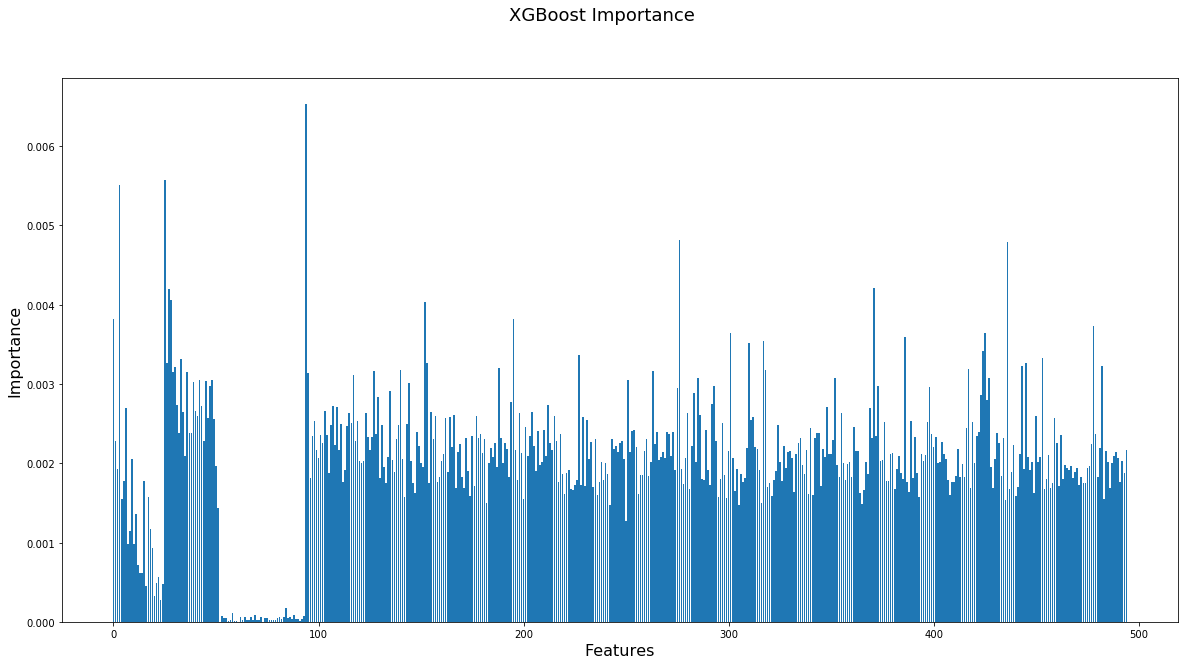

In [92]:
from matplotlib import pyplot
from xgboost import plot_importance
pyplot.figure(figsize=(20,10))
pyplot.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
pyplot.suptitle('XGBoost Importance', fontsize=18)
pyplot.xlabel('Features', fontsize=16)
pyplot.ylabel('Importance', fontsize=16)
pyplot.savefig('all_features_imporance.png')
pyplot.show()

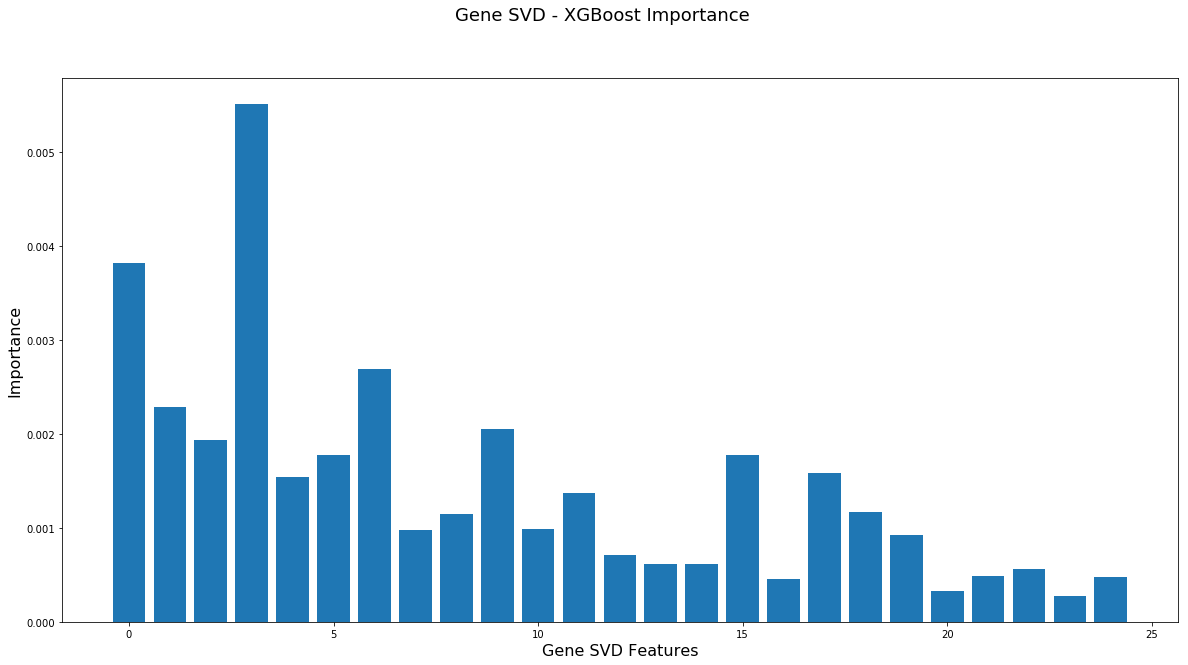

In [93]:
from matplotlib import pyplot
from xgboost import plot_importance
pyplot.figure(figsize=(20,10))
pyplot.bar(range(len(xgb.feature_importances_[:25])), xgb.feature_importances_[:25])
pyplot.suptitle('Gene SVD - XGBoost Importance', fontsize=18)
pyplot.xlabel('Gene SVD Features', fontsize=16)
pyplot.ylabel('Importance', fontsize=16)
pyplot.show()
pyplot.savefig('gene_svd.png')

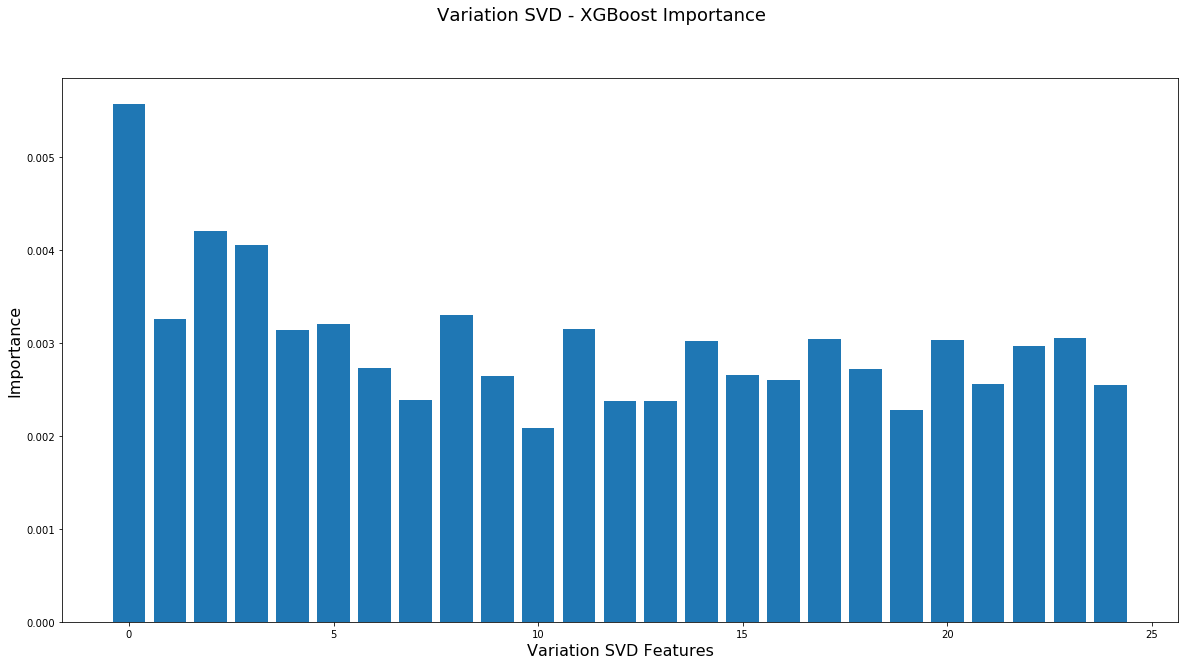

In [94]:
from matplotlib import pyplot
from xgboost import plot_importance
pyplot.figure(figsize=(20,10))
pyplot.bar(range(len(xgb.feature_importances_[25:50])), xgb.feature_importances_[25:50])
pyplot.suptitle('Variation SVD - XGBoost Importance', fontsize=18)
pyplot.xlabel('Variation SVD Features', fontsize=16)
pyplot.ylabel('Importance', fontsize=16)
pyplot.show()
pyplot.savefig('var_svd.png')

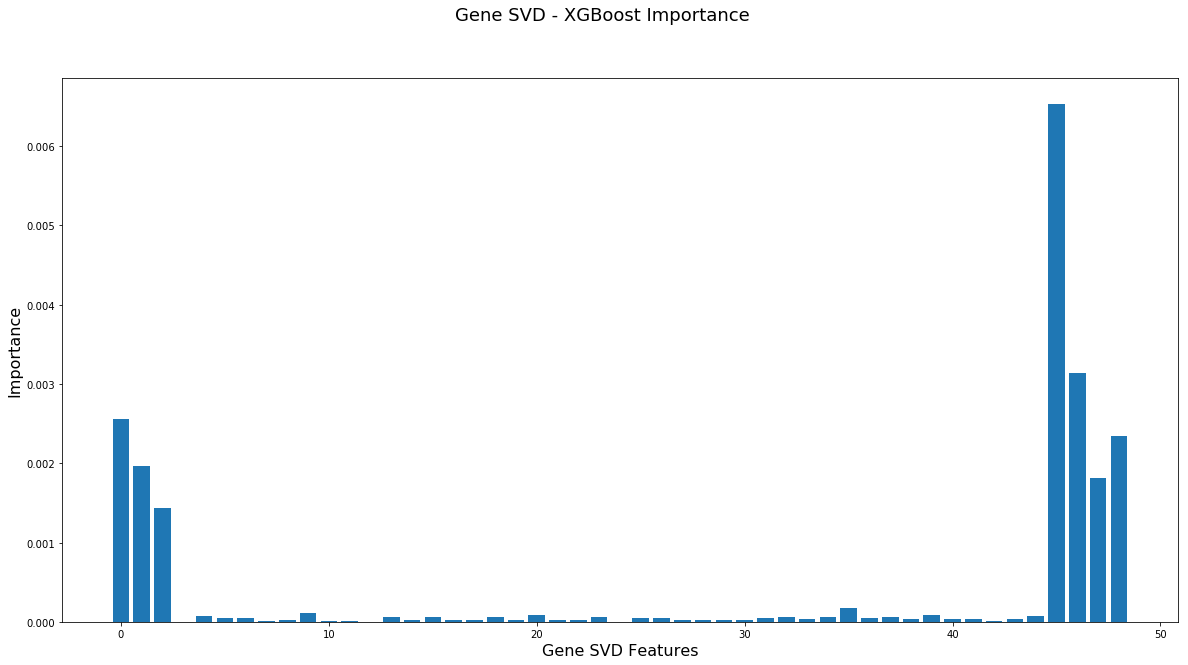

In [97]:
pyplot.figure(figsize=(20,10))
pyplot.bar(range(len(xgb.feature_importances_[49:98])), xgb.feature_importances_[49:98])
pyplot.suptitle('Gene SVD - XGBoost Importance', fontsize=18)
pyplot.xlabel('Gene SVD Features', fontsize=16)
pyplot.ylabel('Importance', fontsize=16)
pyplot.show()
#pyplot.savefig('gene_svd.png')

In [86]:
X_train.columns.values

array(['gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5',
       'gene_6', 'gene_7', 'gene_8', 'gene_9', 'gene_10', 'gene_11',
       'gene_12', 'gene_13', 'gene_14', 'gene_15', 'gene_16', 'gene_17',
       'gene_18', 'gene_19', 'gene_20', 'gene_21', 'gene_22', 'gene_23',
       'gene_24', 'variation_0', 'variation_1', 'variation_2',
       'variation_3', 'variation_4', 'variation_5', 'variation_6',
       'variation_7', 'variation_8', 'variation_9', 'variation_10',
       'variation_11', 'variation_12', 'variation_13', 'variation_14',
       'variation_15', 'variation_16', 'variation_17', 'variation_18',
       'variation_19', 'variation_20', 'variation_21', 'variation_22',
       'variation_23', 'variation_24', 'Elec_Diff', 'Hydro_Diff',
       'Orig_Amino_0', 'Orig_Amino_A', 'Orig_Amino_C', 'Orig_Amino_D',
       'Orig_Amino_E', 'Orig_Amino_F', 'Orig_Amino_G', 'Orig_Amino_H',
       'Orig_Amino_I', 'Orig_Amino_K', 'Orig_Amino_L', 'Orig_Amino_M',
       'Orig_Amino_N', 'Orig

In [74]:
xgb_train_vecs_dbow_sg.columns.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
# save XGBoost DBOW SG model

pickle.dump(xgb, open('models/xgb_dbow_sg_model.sav', 'wb'))

In [ ]:
### CODE FOR LOADING A MODEL

doc2vec_model = Doc2Vec.load('models/doc2vec.model')

In [149]:
pickle.dump(train_vecs_dm, open('train_vecs_dm.pkl', 'wb'))

In [150]:
pickle.dump(test_vecs_dm, open('test_vecs_dm.pkl', 'wb'))

In [4]:
test_vecs_dm = pd.read_pickle('test_vecs_dm.pkl')
y_train_dm = pd.read_pickle('y_train_dm.pkl')
y_test_dm = pd.read_pickle('y_test_dm.pkl')
train_vecs_dm = pd.read_pickle('train_vecs_dm.pkl')

In [50]:
test_vecs_dbow_sg = pd.read_pickle('test_vecs_dbow_sg.pkl')
train_vecs_dbow_sg = pd.read_pickle('train_vecs_dbow_sg.pkl')
new_vecs_dbow_sg = pd.read_pickle('new_vecs_dbow_sg.pkl')

In [157]:
pickle.dump(y_train, open('y_train_dm.pkl', 'wb'))

In [158]:
pickle.dump(y_test, open('y_test_dm.pkl', 'wb'))

In [27]:
import pickle

In [28]:
pickle.dump(test_vecs_dbow_sg, open('test_vecs_dbow_sg.pkl', 'wb'))
pickle.dump(train_vecs_dbow_sg, open('train_vecs_dbow_sg.pkl', 'wb'))
pickle.dump(new_vecs_dbow_sg, open('new_vecs_dbow_sg.pkl', 'wb'))


### Neural Network

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [52]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD

seed = 7
np.random.seed(seed)

In [101]:
# Encode the y train values

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = np_utils.to_categorical((label_encoder.transform(y_train)))


In [105]:
# define the NN model
### THIS IS THE ONE SO FAR

def nn_baseline_model():
    model = Sequential()
    model.add(Dense(512, input_dim=450, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(9, kernel_initializer='normal', activation="softmax"))
    
    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nn_model = nn_baseline_model()

In [55]:
train_nn_svd_dbow_sg.shape[1]

495

In [109]:
# define the LSTM NN model

def nn_baseline_model():
    model = Sequential()
    model.add(LSTM(150,return_sequences=True, input_dim=2))
    model.add(Dropout(0.3))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(9, kernel_initializer='normal', activation="softmax"))
    
    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nn_model = nn_baseline_model()

/Users/Patrick/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/Patrick/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(150, return_sequences=True, input_shape=(None, 2))`


In [102]:
# combine the Gene/Variation SVD columns with the Doc2Vec DBOW SG columns
train_vecs_dbow_sg = np.vstack(train_vecs_dbow_sg)
train_nn_svd_dbow_sg=np.hstack((X_train,train_vecs_dbow_sg))

test_vecs_dbow_sg = np.vstack(test_vecs_dbow_sg)
test_nn_svd_dbow_sg=np.hstack((X_test,test_vecs_dbow_sg))

new_vecs_dbow_sg = np.vstack(new_vecs_dbow_sg)
new_nn_svd_dbow_sg=np.hstack((test_svd,new_vecs_dbow_sg))

In [76]:
X_train.columns.values

array(['gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5',
       'gene_6', 'gene_7', 'gene_8', 'gene_9', 'gene_10', 'gene_11',
       'gene_12', 'gene_13', 'gene_14', 'gene_15', 'gene_16', 'gene_17',
       'gene_18', 'gene_19', 'gene_20', 'gene_21', 'gene_22', 'gene_23',
       'gene_24', 'variation_0', 'variation_1', 'variation_2',
       'variation_3', 'variation_4', 'variation_5', 'variation_6',
       'variation_7', 'variation_8', 'variation_9', 'variation_10',
       'variation_11', 'variation_12', 'variation_13', 'variation_14',
       'variation_15', 'variation_16', 'variation_17', 'variation_18',
       'variation_19', 'variation_20', 'variation_21', 'variation_22',
       'variation_23', 'variation_24', 'Elec_Diff', 'Hydro_Diff',
       'Orig_Amino_0', 'Orig_Amino_A', 'Orig_Amino_C', 'Orig_Amino_D',
       'Orig_Amino_E', 'Orig_Amino_F', 'Orig_Amino_G', 'Orig_Amino_H',
       'Orig_Amino_I', 'Orig_Amino_K', 'Orig_Amino_L', 'Orig_Amino_M',
       'Orig_Amino_N', 'Orig

In [259]:
# combine the Gene/Variation SVD columns with the Doc2Vec DBOW SG columns
train_vecs_dm = np.vstack(train_vecs_dm)
train_nn_svd_vecs_dm=np.hstack((X_train,train_vecs_dm))

test_vecs_dm = np.vstack(test_vecs_dm)
test_nn_svd_vecs_dm=np.hstack((X_test,test_vecs_dm))

new_vecs_dm = np.vstack(new_vecs_dm)
new_nn_svd_vecs_dm=np.hstack((test_svd,new_vecs_dm))





NameError: name 'new_vecs_dm' is not defined

In [249]:
y_train_encoded[10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

In [129]:
# fit the Neural network

nn_estimator=nn_model.fit(train_nn_svd_dbow_sg, y_train_encoded, class_weight='balanced', validation_split=0.2, epochs=10, batch_size=64)

TypeError: Unrecognized keyword arguments: {'pickle_safe': True}

In [107]:
# train/test accuracy of model

print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % \
      (100*nn_estimator.history['acc'][-1], 100*nn_estimator.history['val_acc'][-1]))

Training accuracy: 83.80% / Validation accuracy: 61.84%


In [119]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

figure = SVG(model_to_dot(nn_estimator, show_shapes=True).create(prog='dot', format='svg'))
display(figure)


ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [1]:
from keras.models import load_model

# nn_model.save('nn_model.h5')  # creates a HDF5 file 'my_model.h5'

# returns a compiled model
# identical to the previous one
nn_model = load_model('nn_model.h5')

Using TensorFlow backend.


In [2]:
import pydot
import graphviz
from keras.utils import plot_model
plot_model(nn_model, to_file='nn_model.png')

In [111]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(nn_estimator).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [286]:
# predict proba

y_pred = nn_model.predict(test_nn_svd_dbow_sg)

In [108]:
y_pred_new_nn = nn_model.predict(new_nn_svd_dbow_sg)

In [289]:
y_pred_new_nn

array([[  5.27033582e-03,   4.04403269e-01,   7.39681127e-04, ...,
          5.50934255e-01,   1.16070397e-02,   8.23172799e-04],
       [  2.30512135e-02,   2.46885786e-04,   4.30920487e-03, ...,
          4.83056065e-04,   6.65194166e-05,   5.46176743e-04],
       [  3.69262286e-02,   6.77199336e-03,   9.62832570e-02, ...,
          6.88596815e-02,   1.37716136e-03,   2.22017616e-02],
       ..., 
       [  4.04377024e-05,   9.84755099e-01,   4.74238078e-07, ...,
          1.44647080e-02,   6.92876230e-04,   6.28796579e-06],
       [  3.85499477e-01,   2.38553509e-02,   2.26214789e-02, ...,
          1.43354595e-01,   1.91575494e-02,   1.30309597e-01],
       [  3.89691710e-01,   6.93865269e-02,   4.40288009e-03, ...,
          1.24334069e-02,   3.95144857e-02,   2.12104176e-03]], dtype=float32)

In [290]:
new_index = test_master['ID'].values

submission = pd.DataFrame(y_pred_new_nn)
submission['id'] = new_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("nn_svd_d2v_pmp.csv",index=False)

In [568]:
test_3d = test_nn_svd_dbow_sg[: ,: , np.newaxis]

y_nn_cats= nn_model.predict_classes(test_3d)

665/665 [==============================] - 47s    


In [569]:
y_nn_cats = y_nn_cats+1

In [570]:
y_nn_cats

array([2, 1, 6, 1, 2, 5, 7, 1, 2, 7, 4, 7, 2, 5, 7, 2, 7, 7, 4, 4, 7, 7, 4,
       1, 7, 7, 7, 1, 6, 3, 1, 7, 5, 6, 2, 1, 6, 1, 4, 1, 6, 6, 3, 7, 7, 4,
       7, 7, 1, 7, 1, 7, 7, 7, 6, 7, 5, 7, 4, 4, 7, 3, 7, 1, 1, 4, 6, 4, 4,
       7, 7, 6, 7, 5, 2, 7, 7, 7, 6, 4, 4, 7, 7, 9, 5, 7, 4, 7, 1, 6, 2, 4,
       7, 4, 7, 7, 1, 6, 1, 5, 7, 1, 4, 7, 4, 7, 1, 2, 4, 6, 7, 1, 7, 1, 2,
       1, 7, 1, 7, 4, 4, 4, 7, 5, 7, 7, 4, 1, 7, 4, 1, 7, 7, 5, 7, 1, 7, 7,
       4, 4, 7, 1, 7, 7, 1, 4, 4, 7, 7, 2, 2, 1, 4, 2, 4, 2, 4, 7, 6, 7, 1,
       7, 7, 7, 7, 1, 4, 4, 1, 7, 6, 6, 7, 7, 2, 6, 7, 7, 1, 7, 2, 4, 7, 4,
       1, 4, 1, 1, 6, 7, 5, 6, 4, 1, 7, 5, 6, 4, 9, 1, 3, 7, 2, 4, 4, 2, 7,
       7, 1, 1, 1, 2, 7, 4, 5, 7, 4, 7, 1, 2, 2, 4, 5, 3, 1, 7, 4, 1, 4, 7,
       1, 1, 5, 7, 7, 1, 7, 7, 5, 4, 1, 2, 7, 2, 2, 5, 7, 2, 5, 7, 1, 1, 5,
       7, 4, 7, 1, 1, 7, 3, 7, 7, 1, 1, 6, 7, 7, 7, 4, 6, 4, 7, 1, 1, 4, 2,
       4, 6, 6, 7, 9, 1, 4, 2, 4, 4, 4, 7, 4, 7, 2, 4, 7, 4, 3, 5, 2, 4, 4,
       4, 7,

In [571]:
np.mean(y_nn_cats == y_test)

0.61052631578947369

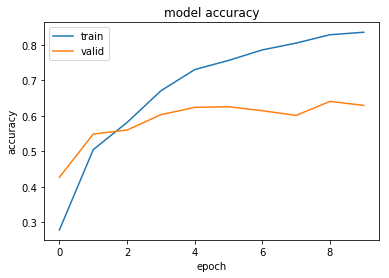

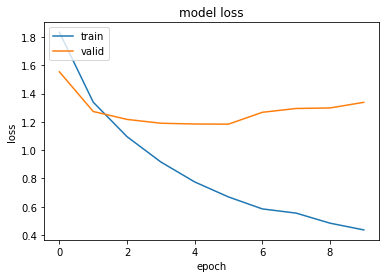

In [572]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(nn_estimator.history['acc'])
plt.plot(nn_estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(nn_estimator.history['loss'])
plt.plot(nn_estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [36]:
import sklearn

In [573]:
#print('Accuracy score: ' + str(nn_model.score(test_vecs_dbow_sgnn, y_test)))

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_nn_cats,y_test))

confusion_matrix:
 [[ 72   3   1  20  15   6   3   0   0]
 [  5  37   0   5   4   1  29   0   2]
 [  0   0  10   2   1   0   4   0   0]
 [ 15   2   3  92   8   1   3   0   0]
 [  8   5   0   4  12   4   6   0   1]
 [  6   2   1   3   5  32   1   0   0]
 [  8  47   4  13   5   1 148   1   1]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   3]]


In [218]:
train_nn_svd_dbow_sg = np.expand_dims(train_nn_svd_dbow_sg, axis=2)

In [562]:
train_nn_svd_dbow_sg.shape

(2656, 450)

In [251]:
## CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

def baseline_model():
    model = Sequential()
    model.add(Conv1D(256, name="conv1", kernel_size = 4, strides = 1, input_shape = (450,1), activation='relu'))
    model.add(MaxPooling1D(pool_size = 2, strides = 2))
    model.add(Conv1D(256, 4, activation='relu', name="conv2"))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dense(512, kernel_initializer='normal', name="dense1"))
    model.add(Dropout(0.5))
    model.add(Dense(512, kernel_initializer='normal', name="dense2"))
    model.add(Dropout(0.3))
    model.add(Dense(512, kernel_initializer='normal', name="dense3"))
    model.add(Dropout(0.2))
    model.add(Dense(128, kernel_initializer='normal', name="dense4"))
    model.add(Dense(9, kernel_initializer='normal', name="dense5"))
#     model.add(Flatten())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nn_model = baseline_model()



In [565]:
train_3d = train_nn_svd_dbow_sg[: ,: , np.newaxis]

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling1D, Flatten

def baseline_model():
    model = Sequential()
    model.add(Conv1D(256, kernel_size = 4, activation = 'relu', input_shape = (450,1)))
    model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(Conv1D(256, kernel_size = 4, activation = 'relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Flatten())
    model.add(Dense(9, kernel_initializer='normal', activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nn_model = baseline_model()



In [566]:
estimator=nn_model.fit(train_3d, y_train_encoded, class_weight='balanced', validation_split=0.2, epochs=10, batch_size=64)

Train on 2124 samples, validate on 532 samples
Epoch 1/10
2124/2124 [==============================] - 450s - loss: 1.8989 - acc: 0.2462 - val_loss: 1.8509 - val_acc: 0.3534
Epoch 2/10
2124/2124 [==============================] - 414s - loss: 1.8188 - acc: 0.3004 - val_loss: 1.8286 - val_acc: 0.4699
Epoch 3/10
2124/2124 [==============================] - 429s - loss: 1.5019 - acc: 0.4812 - val_loss: 1.3774 - val_acc: 0.5414
Epoch 4/10
2124/2124 [==============================] - 498s - loss: 1.1394 - acc: 0.5998 - val_loss: 1.2733 - val_acc: 0.5977
Epoch 5/10
2124/2124 [==============================] - 424s - loss: 0.9726 - acc: 0.6563 - val_loss: 1.2148 - val_acc: 0.5921
Epoch 6/10
2124/2124 [==============================] - 431s - loss: 0.8611 - acc: 0.7034 - val_loss: 1.2126 - val_acc: 0.6222
Epoch 7/10
2124/2124 [==============================] - 433s - loss: 0.7682 - acc: 0.7185 - val_loss: 1.2400 - val_acc: 0.5940
Epoch 8/10
2124/2124 [==============================] - 469s - l

In [254]:
from keras.wrappers.scikit_learn import KerasClassifier
nn_estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=64)
nn_estimator.fit(train_nn_svd_dbow_sg, y_train_encoded, validation_split=0.2)


#nn_estimator=nn_model.fit(train_nn_svd_dbow_sg, y_train_encoded, class_weight='balanced', validation_split=0.2, epochs=10, batch_size=64)

ValueError: Error when checking target: expected dense5 to have 3 dimensions, but got array with shape (2656, 9)

In [214]:
train_nn_svd_dbow_sg.shape

(2656, 450)

In [ ]:
# export test predictions to csv
### NEED TO CONFORM COLUMNS W/ SAM's CODE

test_index = test_x['ID'].values

submission = pd.DataFrame(y_pred)
submission['id'] = test_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("submission_all.csv",index=False)

### Model Stacking

In [544]:
rf_context_tfidf = pd.read_csv("Final_Models/Jing_submission_rf_context.csv")
svm_tfidf = pd.read_csv("Final_Models/submission_SVM_corrected_ksc.csv")
nn_svd_d2v = pd.read_csv("Final_Models/nn_svd_d2v_pmp.csv")
svm_svd_d2v = pd.read_csv("Final_Models/svm_svd_d2v_pmp.csv")
rf_svd_d2v = pd.read_csv("Final_Models/rf_svd_d2v_pmp.csv")
multinomlog_svd_d2v = pd.read_csv("Final_Models/multinomlog_svd_d2v_pmp.csv")
gb_svd_d2v = pd.read_csv("Final_Models/gb_svd_d2v_pmp.csv")
xgb_svd_d2v = pd.read_csv("Final_Models/xgb_svd_d2v_pmp.csv")
nn_context_tfidf = pd.read_csv("Final_Models/Jing_submission_nn_context.csv")

In [545]:
len(nn_context_tfidf)

5662

In [546]:
rf_con_avg = pd.DataFrame([rf_context_tfidf.mean()])

rf_context_tfidf = rf_context_tfidf.append(rf_con_avg, ignore_index=True)
rf_context_tfidf = rf_context_tfidf.append(rf_con_avg, ignore_index=True)
rf_context_tfidf = rf_context_tfidf.append(rf_con_avg, ignore_index=True)
rf_context_tfidf = rf_context_tfidf.append(rf_con_avg, ignore_index=True)
rf_context_tfidf = rf_context_tfidf.append(rf_con_avg, ignore_index=True)
rf_context_tfidf = rf_context_tfidf.append(rf_con_avg, ignore_index=True)

rf_context_tfidf.loc[5662]['ID'] = '5662'
rf_context_tfidf.loc[5663]['ID'] = '5663'
rf_context_tfidf.loc[5664]['ID'] = '5664'
rf_context_tfidf.loc[5665]['ID'] = '5665'
rf_context_tfidf.loc[5666]['ID'] = '5666'
rf_context_tfidf.loc[5667]['ID'] = '5667'

In [547]:
nn_con_avg = pd.DataFrame([nn_context_tfidf.mean()])

nn_context_tfidf = nn_context_tfidf.append(nn_con_avg, ignore_index=True)
nn_context_tfidf = nn_context_tfidf.append(nn_con_avg, ignore_index=True)
nn_context_tfidf = nn_context_tfidf.append(nn_con_avg, ignore_index=True)
nn_context_tfidf = nn_context_tfidf.append(nn_con_avg, ignore_index=True)
nn_context_tfidf = nn_context_tfidf.append(nn_con_avg, ignore_index=True)
nn_context_tfidf = nn_context_tfidf.append(nn_con_avg, ignore_index=True)

nn_context_tfidf.loc[5662]['ID'] = '5662'
nn_context_tfidf.loc[5663]['ID'] = '5663'
nn_context_tfidf.loc[5664]['ID'] = '5664'
nn_context_tfidf.loc[5665]['ID'] = '5665'
nn_context_tfidf.loc[5666]['ID'] = '5666'
nn_context_tfidf.loc[5667]['ID'] = '5667'

In [548]:
rf_context_tfidf.name = 'rf_context_tfidf'
svm_tfidf.name = 'svm_tfidf'
nn_svd_d2v.name = 'nn_svd_d2v'
svm_svd_d2v.name = 'svm_svd_d2v'
rf_svd_d2v.name = 'rf_svd_d2v'
multinomlog_svd_d2v.name = 'multinomlog_svd_d2v'
gb_svd_d2v.name = 'gb_svd_d2v'
xgb_svd_d2v.name = 'xgb_svd_d2v'
nn_context_tfidf.name = 'nn_context_tfidf'

In [549]:
print(len(rf_context_tfidf))
print(len(svm_tfidf))
print(len(nn_svd_d2v))
print(len(svm_svd_d2v))
print(len(rf_svd_d2v))
print(len(multinomlog_svd_d2v))
print(len(gb_svd_d2v))
print(len(xgb_svd_d2v))
print(len(nn_context_tfidf))


5668
5668
5668
5668
5668
5668
5668
5668
5668


In [550]:
def rename_cols(df):
    for column_name in df.columns.values:
        df.rename(columns={column_name: str(df.name) + column_name}, inplace=True)

In [551]:
rename_cols(rf_context_tfidf)
rename_cols(svm_tfidf)
rename_cols(nn_svd_d2v)
rename_cols(svm_svd_d2v)
rename_cols(rf_svd_d2v)
rename_cols(multinomlog_svd_d2v)
rename_cols(gb_svd_d2v)
rename_cols(xgb_svd_d2v)
rename_cols(nn_context_tfidf)

In [552]:
print(len(rf_context_tfidf))
print(len(svm_tfidf))
print(len(nn_svd_d2v))
print(len(svm_svd_d2v))
print(len(rf_svd_d2v))
print(len(multinomlog_svd_d2v))
print(len(gb_svd_d2v))
print(len(xgb_svd_d2v))
print(len(nn_context_tfidf))

5668
5668
5668
5668
5668
5668
5668
5668
5668


In [553]:
rf_context_tfidf.drop('rf_context_tfidfID', axis=1, inplace=True)
nn_context_tfidf.drop('nn_context_tfidfID', axis=1, inplace=True)

In [554]:
combined = svm_tfidf
print(len(combined))
combined = combined.join(nn_svd_d2v)
print(len(combined))
combined = combined.join(svm_svd_d2v)
print(len(combined))
combined = combined.join(rf_svd_d2v)
print(len(combined))
combined = combined.join(multinomlog_svd_d2v)
print(len(combined))
combined = combined.join(gb_svd_d2v)
print(len(combined))
combined = combined.join(xgb_svd_d2v)
print(len(combined))
combined = combined.join(rf_context_tfidf)
print(len(combined))
combined = combined.join(nn_context_tfidf)
print(len(combined))

5668
5668
5668
5668
5668
5668
5668
5668
5668


In [555]:
combined['ID'] = combined.index

In [556]:
combined.drop('svm_tfidfid', axis=1, inplace=True)
combined.drop('nn_svd_d2vid', axis=1, inplace=True)
combined.drop('svm_svd_d2vid', axis=1, inplace=True)
combined.drop('rf_svd_d2vid', axis=1, inplace=True)
combined.drop('multinomlog_svd_d2vid', axis=1, inplace=True)
combined.drop('gb_svd_d2vid', axis=1, inplace=True)
combined.drop('xgb_svd_d2vid', axis=1, inplace=True)


In [557]:
combined['class1'] = (1/9)*combined['rf_context_tfidfclass1']+(1/9)*combined['svm_tfidfclass1']+(1/9)*combined['nn_svd_d2vclass1']+(1/9)*combined['svm_svd_d2vclass1']+(1/9)*combined['rf_svd_d2vclass1']+(1/9)*combined['multinomlog_svd_d2vclass1']+(1/9)*combined['gb_svd_d2vclass1']+(1/9)*combined['xgb_svd_d2vclass1']+(1/9)*combined['nn_context_tfidfclass1']
combined['class2'] = (1/9)*combined['rf_context_tfidfclass2']+(1/9)*combined['svm_tfidfclass2']+(1/9)*combined['nn_svd_d2vclass2']+(1/9)*combined['svm_svd_d2vclass2']+(1/9)*combined['rf_svd_d2vclass2']+(1/9)*combined['multinomlog_svd_d2vclass2']+(1/9)*combined['gb_svd_d2vclass2']+(1/9)*combined['xgb_svd_d2vclass2']+(1/9)*combined['nn_context_tfidfclass2']
combined['class3'] = (1/9)*combined['rf_context_tfidfclass3']+(1/9)*combined['svm_tfidfclass3']+(1/9)*combined['nn_svd_d2vclass3']+(1/9)*combined['svm_svd_d2vclass3']+(1/9)*combined['rf_svd_d2vclass3']+(1/9)*combined['multinomlog_svd_d2vclass3']+(1/9)*combined['gb_svd_d2vclass3']+(1/9)*combined['xgb_svd_d2vclass3']+(1/9)*combined['nn_context_tfidfclass3']
combined['class4'] = (1/9)*combined['rf_context_tfidfclass4']+(1/9)*combined['svm_tfidfclass4']+(1/9)*combined['nn_svd_d2vclass4']+(1/9)*combined['svm_svd_d2vclass4']+(1/9)*combined['rf_svd_d2vclass4']+(1/9)*combined['multinomlog_svd_d2vclass4']+(1/9)*combined['gb_svd_d2vclass4']+(1/9)*combined['xgb_svd_d2vclass4']+(1/9)*combined['nn_context_tfidfclass4']
combined['class5'] = (1/9)*combined['rf_context_tfidfclass5']+(1/9)*combined['svm_tfidfclass5']+(1/9)*combined['nn_svd_d2vclass5']+(1/9)*combined['svm_svd_d2vclass5']+(1/9)*combined['rf_svd_d2vclass5']+(1/9)*combined['multinomlog_svd_d2vclass5']+(1/9)*combined['gb_svd_d2vclass5']+(1/9)*combined['xgb_svd_d2vclass5']+(1/9)*combined['nn_context_tfidfclass5']
combined['class6'] = (1/9)*combined['rf_context_tfidfclass6']+(1/9)*combined['svm_tfidfclass6']+(1/9)*combined['nn_svd_d2vclass6']+(1/9)*combined['svm_svd_d2vclass6']+(1/9)*combined['rf_svd_d2vclass6']+(1/9)*combined['multinomlog_svd_d2vclass6']+(1/9)*combined['gb_svd_d2vclass6']+(1/9)*combined['xgb_svd_d2vclass6']+(1/9)*combined['nn_context_tfidfclass6']
combined['class7'] = (1/9)*combined['rf_context_tfidfclass7']+(1/9)*combined['svm_tfidfclass7']+(1/9)*combined['nn_svd_d2vclass7']+(1/9)*combined['svm_svd_d2vclass7']+(1/9)*combined['rf_svd_d2vclass7']+(1/9)*combined['multinomlog_svd_d2vclass7']+(1/9)*combined['gb_svd_d2vclass7']+(1/9)*combined['xgb_svd_d2vclass7']+(1/9)*combined['nn_context_tfidfclass7']
combined['class8'] = (1/9)*combined['rf_context_tfidfclass8']+(1/9)*combined['svm_tfidfclass8']+(1/9)*combined['nn_svd_d2vclass8']+(1/9)*combined['svm_svd_d2vclass8']+(1/9)*combined['rf_svd_d2vclass8']+(1/9)*combined['multinomlog_svd_d2vclass8']+(1/9)*combined['gb_svd_d2vclass8']+(1/9)*combined['xgb_svd_d2vclass8']+(1/9)*combined['nn_context_tfidfclass8']
combined['class9'] = (1/9)*combined['rf_context_tfidfclass9']+(1/9)*combined['svm_tfidfclass9']+(1/9)*combined['nn_svd_d2vclass9']+(1/9)*combined['svm_svd_d2vclass9']+(1/9)*combined['rf_svd_d2vclass9']+(1/9)*combined['multinomlog_svd_d2vclass9']+(1/9)*combined['gb_svd_d2vclass9']+(1/9)*combined['xgb_svd_d2vclass9']+(1/9)*combined['nn_context_tfidfclass9']


In [558]:
combined_avg = combined[['class1','class2','class3','class4','class5','class6','class7','class8','class9','ID']]

In [561]:
combined_avg

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.042805,0.188448,0.010415,0.036203,0.026625,0.036764,0.648373,0.006470,0.003898,0
1,0.193260,0.073825,0.026690,0.458977,0.047355,0.065973,0.107768,0.011492,0.014660,1
2,0.099767,0.113050,0.046377,0.179272,0.037894,0.060432,0.437910,0.013948,0.011349,2
3,0.046491,0.323624,0.026636,0.060724,0.026193,0.031584,0.471122,0.008938,0.004688,3
4,0.233403,0.090182,0.019124,0.404349,0.042428,0.044172,0.142754,0.014826,0.008761,4
5,0.219619,0.219289,0.021837,0.246470,0.044449,0.040962,0.180929,0.011581,0.014864,5
6,0.182197,0.197488,0.023575,0.081007,0.032876,0.054917,0.408993,0.009514,0.009435,6
7,0.095286,0.082075,0.029039,0.387945,0.090712,0.074012,0.221489,0.010660,0.008782,7
8,0.143225,0.288549,0.022848,0.084035,0.033028,0.058127,0.339011,0.019678,0.011500,8
9,0.066556,0.253091,0.020758,0.054447,0.023403,0.039058,0.527959,0.009586,0.005142,9


In [559]:
len(combined_avg)

5668

In [560]:
combined_avg.to_csv("combined_avg_ensemble_1.csv",index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression

multinomial = LogisticRegression(multi_class='ovr', ### one-vs-rest
                                 class_weight='balanced',
                                 solver='liblinear',
                                 penalty='l1',
                                 C=.1)

multinomial.fit(train_vecs_dm, y_train)
print('Accuracy score: ' + str(multinomial.score(test_vecs_dm, y_test)))
multinomial_pred = multinomial.predict(test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,multinomial_pred))